# Model Convergence

In [1]:
import os
import sys
from pathlib import Path

repo_root = Path(os.getcwd()).parent
sys.path.insert(0, str(repo_root))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator

from pipeline import harmony
from harmonia.cosmology import BaseModel
from harmonia.reader import Couplings, SphericalCorrelator

plt.style.use(harmony)

In [3]:
storage = repo_root/"storage"/"raw"/"survey_products"

couplings = Couplings.load(
    storage/
    "couplings-(rmax=500.0,kmax=0.055,mask=random0_BOSS_DR12v5_CMASS_North,selection=[100.0,500.0],pixel=256).npz"
)
couplings_ref = Couplings.load(
    storage/
    "couplings-(rmax=500.0,kmax=0.06,mask=random0_BOSS_DR12v5_CMASS_North,selection=[100.0,500.0],pixel=256).npz"
)
couplings_poor = Couplings.load(
    storage/
    "couplings-(rmax=500.0,kmax=0.04,mask=random0_BOSS_DR12v5_CMASS_North,selection=[100.0,500.0],pixel=256).npz"
)

In [4]:
cosmo = BaseModel(repo_root/"storage"/"external"/"cosmology"/"simulation-GadgetAHF.txt")

[2020-06-28 21:36:15 (+0:00:05) INFO] Created cosmological model with parameters:
{'Omega0_b': 0.044, 'Omega0_cdm': 0.226, 'h': 0.7, 'sigma8': 0.8}.


In [5]:
model = SphericalCorrelator(
    couplings.disc, 
    redshift=1., cosmo=cosmo, couplings=couplings, ini_shot_noise=False
)

model_poor = SphericalCorrelator(
    couplings_poor.disc, 
    redshift=1., cosmo=cosmo, couplings=couplings_poor, ini_shot_noise=False
)

model_ref = SphericalCorrelator(
    couplings_ref.disc, 
    redshift=1., cosmo=cosmo, couplings=couplings_ref, ini_shot_noise=False
)

[2020-06-28 21:36:20 (+0:00:09) INFO] Compiling fixed angular sums...
Angular sum compilation: 100%|██████████| 117370/117370 [06:00<00:00, 325.31it/s]
[2020-06-28 21:42:20 (+0:06:10) INFO] ... compiled fixed angular sums.
[2020-06-28 21:42:25 (+0:06:14) INFO] Compiling fixed angular sums...
Angular sum compilation: 100%|██████████| 25425/25425 [00:34<00:00, 736.02it/s]
[2020-06-28 21:42:59 (+0:06:49) INFO] ... compiled fixed angular sums.
[2020-06-28 21:43:04 (+0:06:53) INFO] Compiling fixed angular sums...
Angular sum compilation: 100%|██████████| 166176/166176 [10:50<00:00, 255.44it/s]
[2020-06-28 21:53:54 (+0:17:44) INFO] ... compiled fixed angular sums.


In [6]:
spectrum = model.radialised_power(b_1=1.)
spectrum_poor = model_poor.radialised_power(b_1=1.)
spectrum_ref = model_ref.radialised_power(b_1=1.)

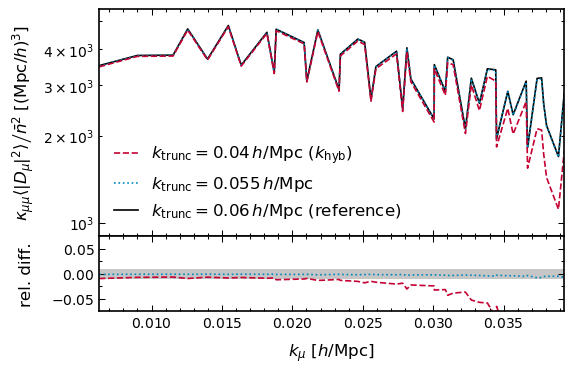

In [7]:
red, blue = '#C40233', '#0087BD'

overlap = len(spectrum_poor['wavenumbers'])

fig = plt.figure(figsize=(6., 4.), dpi=100)

main = plt.subplot2grid((4, 1), (0, 0), rowspan=3)

main.semilogy(
    spectrum_ref['wavenumbers'][:overlap], spectrum_ref['mode_powers'][:overlap], 
    ls='-', label=r'$k_\mathrm{trunc} = 0.06\,h/\mathrm{Mpc}$ (reference)', zorder=-1
)
main.semilogy(
    spectrum['wavenumbers'][:overlap], spectrum['mode_powers'][:overlap], 
    c=blue, ls=':', label=r'$k_\mathrm{trunc} = 0.055\,h/\mathrm{Mpc}$'
)
main.semilogy(
    spectrum_poor['wavenumbers'][:overlap], spectrum_poor['mode_powers'][:overlap], 
    c=red, ls='--', label=r'$k_\mathrm{trunc} = 0.04\,h/\mathrm{Mpc}$ ($k_\mathrm{hyb}$)'
)

handles, labels = main.get_legend_handles_labels()

main.legend(reversed(handles), reversed(labels), handlelength=1.4)
main.tick_params(which='both', labelbottom=False)
main.set_ylim(9e2, 5.5e3);
main.set_ylabel(
    r"$\kappa_{\mu\mu} \left. \langle\vert{D_\mu}\vert^2\rangle\right/ \bar{n}^2$ [$(\mathrm{Mpc}/h)^3$]",
    labelpad=5,
);

error = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=main)


error.plot(
    spectrum_ref['wavenumbers'][:overlap], 
    spectrum['mode_powers'][:overlap]/spectrum_ref['mode_powers'][:overlap] - 1,
    c=blue, ls=':',
)
error.plot(
    spectrum_ref['wavenumbers'][:overlap], 
    spectrum_poor['mode_powers'][:overlap]/spectrum_ref['mode_powers'][:overlap] - 1,
    c=red, ls='--',
)
error.axhspan(-0.01, 0.01, fc='0.67', ec='none', alpha=0.67)

error.xaxis.set_minor_locator(AutoMinorLocator())
error.yaxis.set_minor_locator(AutoMinorLocator(2))
error.set_xlim(spectrum_ref['wavenumbers'][0], spectrum_ref['wavenumbers'][overlap-1]);
error.set_ylim(-0.075, 0.075);
error.set_xlabel(r"$k_\mu$ [$h/\mathrm{Mpc}$]", labelpad=8)
error.set_ylabel(r"rel. diff.", labelpad=12)

fig.savefig(repo_root/"notebooks"/"publications"/"convergence_check.pdf")